# STEP 1 - Learning for social influence
Assume that all the properties of the graph are known except for the edge activation
probabilities. Apply the greedy algorithm to the problem of maximizing the expected number
of activated customers, where each edge activation probability is replaced with its upper
confidence bound (in a UCB1-like fashion). Furthermore, apply the greedy algorithm to the
same problem when estimating edge activation probabilities with Beta distributions and
sampling is used (in a TS-like fashion). Report the plots with the average (over a sufficiently
large number of runs) value and standard deviation of the cumulative regret, cumulative
reward, instantaneous regret, and instantaneous reward.

In [238]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from scipy.optimize import linear_sum_assignment


In [239]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [240]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1

In [241]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)
    
    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)
        
    def expectations(self):
        return self.empirical_means


In [242]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means

        

In [243]:
def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [314]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def get_reward(node_class, product_class, rewards_parameters):
    return np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])


def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 3, 50, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]
        

        while units > [0, 0, 0]:

            for customer in class_activation_flow:

                # find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

# Estimation of probabilities

In [261]:
n_arms = 30
edge_rate=0.1
graph_structure = np.random.binomial(1, edge_rate, (n_arms, n_arms))
graph_probabilities = np.random.uniform(0.01, 0.99, (n_arms, n_arms)) * graph_structure
graph_probabilities

array([[0.        , 0.        , 0.72893407, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.59690467, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05573249, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.14088941,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.20870881, 0.        , 0.        , 0.85905737],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

### UCB Learner

In [264]:
def UCB_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ucb_env = Environment(probabilities=p)
        # Initialize learner
        ucb_learner = UCBLearner(n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = ucb_learner.pull_arm()
            reward = ucb_env.round(pulled_arm)
            ucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [265]:
import numpy as np

UCB_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = UCB_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    UCB_estimated_graph_probabilities.append(arm_probabilities)

UCB_estimated_graph_probabilities = np.array(UCB_estimated_graph_probabilities)
UCB_estimated_graph_probabilities = np.transpose(UCB_estimated_graph_probabilities, (1, 0, 2))


for table in UCB_estimated_graph_probabilities:
    table = table*graph_structure


Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.76it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.67it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.28it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.80it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.43it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.78it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.67it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.58it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.60it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.86it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.06it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.65it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.76it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.09it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.35it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.91it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.34it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.63it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.37it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.28it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.21it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.85it/s]


### TS Learner

In [266]:
def TS_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ts_env = Environment(probabilities=p)
        # Initialize learner
        ts_learner = TSLearner(n_arms)

        for t in range(0, T):
            # TS-UCB Learner
            pulled_arm = ts_learner.pull_arm()
            reward = ts_env.round(pulled_arm)
            ts_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ts_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [267]:
import numpy as np

TS_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = TS_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    TS_estimated_graph_probabilities.append(arm_probabilities)

TS_estimated_graph_probabilities = np.array(TS_estimated_graph_probabilities)
TS_estimated_graph_probabilities = np.transpose(TS_estimated_graph_probabilities, (1, 0, 2))

for table in TS_estimated_graph_probabilities:
    table = table*graph_structure


Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.93it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.67it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.90it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.74it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.14it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.58it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.06it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.81it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.99it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.92it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.58it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.33it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.70it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.09it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.77it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.13it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.34it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.05it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.81it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.74it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.22it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.13it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.23it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.50it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.03it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.23it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.12it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.46it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.56it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.40it/s]


In [268]:
new_TS_estimated_graph_probabilities = []
for table in TS_estimated_graph_probabilities:
    cleaned_table = table*graph_structure
    new_TS_estimated_graph_probabilities.append(cleaned_table)


In [269]:
TS_estimated_graph_probabilities = new_TS_estimated_graph_probabilities

#### Evaluating Edge Activation Prob. Estimation

In [271]:
repeated_array = np.tile(graph_probabilities, (365, 1, 1))
original_probabilities = repeated_array.reshape((365, 30, 30))

In [272]:
UCB_nodes_probabilities = []
for i in range(len(UCB_estimated_graph_probabilities)):
    nodes_only = UCB_estimated_graph_probabilities[i]*graph_structure
    UCB_nodes_probabilities.append(nodes_only)

UCB_regret = np.sum((original_probabilities - UCB_nodes_probabilities)*graph_structure, axis=(1, 2))

In [273]:
TS_nodes_probabilities = []
for i in range(len(TS_estimated_graph_probabilities)):
    nodes_only = TS_estimated_graph_probabilities[i]*graph_structure
    TS_nodes_probabilities.append(nodes_only)

TS_regret = np.sum((original_probabilities - TS_nodes_probabilities)*graph_structure, axis=(1, 2))

In [ ]:
reward_UCB = [np.sum(i) for i in UCB_nodes_probabilities]
reward_TS = [np.sum(i) for i in TS_nodes_probabilities]
optimum = [np.sum(graph_probabilities) for i in range(T)]

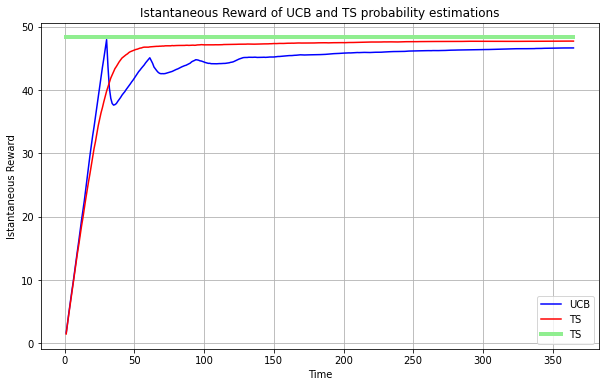

In [285]:
time_periods = range(1, 366)

# Plot the two lists
plt.figure(figsize=(10, 6))

plt.plot(time_periods, reward_UCB, color='blue', linestyle='-', label='UCB')
plt.plot(time_periods, reward_TS, color='red', linestyle='-', label='TS')
plt.plot(time_periods, optimum, color='lightgreen', linestyle='-', label='TS', linewidth=4)

plt.xlabel('Time')
plt.ylabel('Istantaneous Reward')
plt.title('Istantaneous Reward of UCB and TS probability estimations')

plt.legend()
plt.grid()

plt.show()


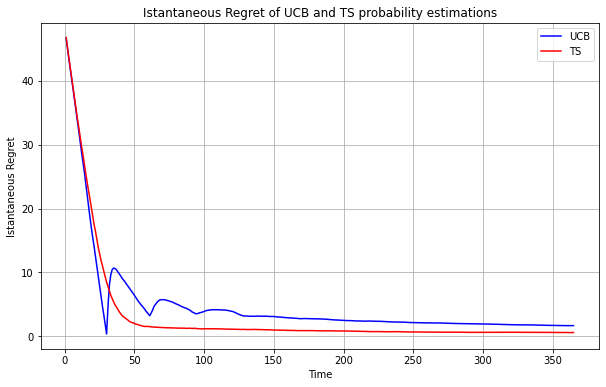

In [290]:
time_periods = range(1, 366)

# Plot the two lists
plt.figure(figsize=(10, 6))

plt.plot(time_periods, UCB_regret, color='blue', linestyle='-', label='UCB')
plt.plot(time_periods, TS_regret, color='red', linestyle='-', label='TS')

plt.xlabel('Time')
plt.ylabel('Istantaneous Regret')
plt.title('Istantaneous Regret of UCB and TS probability estimations')

plt.legend()
plt.grid()

plt.show()





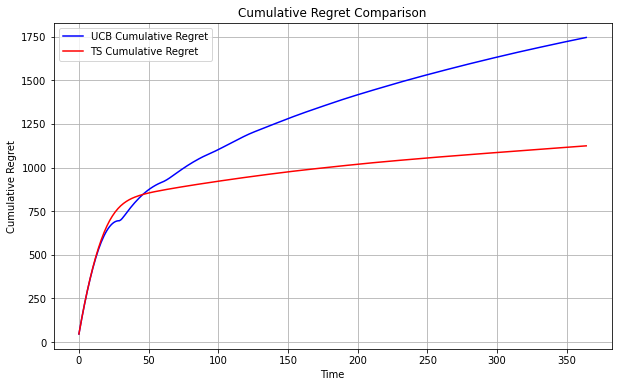

In [327]:
UCB_cumulative_regret = np.cumsum(UCB_regret)
TS_cumulative_regret = np.cumsum(TS_regret)

# Create the cumulative regret plot
plt.figure(figsize=(10, 6))
plt.plot(UCB_cumulative_regret, label='UCB Cumulative Regret', color="blue")
plt.plot(TS_cumulative_regret, label='TS Cumulative Regret', color = "red")
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Comparison')
plt.legend()
plt.grid()
plt.show()







## Computing Rewards 

In [309]:
node_classes = 3
product_classes = 3
products_per_class = 3
T = 365

means = np.random.uniform(1, 20, size=(3,3))
std_dev = np.random.uniform(0, 1, size=(3,3))
rewards_parameters = (means, std_dev)
customer_assignments = np.random.choice([0,1,2], size=30)

#### Rewards with UCB Learner

In [318]:
n_exp = 25

UCB_mean_rewards_per_round = []
UCB_std_dev_rewards_per_round = []
for table in tqdm(range(T)):
    table = UCB_estimated_graph_probabilities[table]
    clairvoyant_output =  clairvoyant(table, graph_probabilities, customer_assignments, rewards_parameters, rewards_parameters, 5)
    UCB_mean_rewards_per_round.append(clairvoyant_output[0])
    UCB_std_dev_rewards_per_round.append(clairvoyant_output[1])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 182.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 215.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 257.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 183.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 233.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 181.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 158.24it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.83it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.13it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.06it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.88it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.49it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.36it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.42it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.94it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.82it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.45it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.57it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.01it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.39it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.16it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.06it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.33it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.82it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.12it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.57it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.26it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.65it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.41it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.40it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.51it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.78it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.58it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.59it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.21it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.48it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.75it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.36it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.97it/s]

100%|███████████████████████████

#### Rewards with TS Learner


In [319]:
n_exp = 25

TS_mean_rewards_per_round = []
TS_std_dev_rewards_per_round = []
for table in tqdm(range(T)):
    table = TS_estimated_graph_probabilities[table]
    clairvoyant_output =  clairvoyant(table, graph_probabilities, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    TS_mean_rewards_per_round.append(clairvoyant_output[0])
    TS_std_dev_rewards_per_round.append(clairvoyant_output[1])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 202.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 179.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 208.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 186.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 218.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 202.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 194.88it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.17it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.69it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.02it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.13it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.79it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.99it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.35it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.12it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.10it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.42it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.81it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.95it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.86it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.45it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.66it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.49it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.81it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.52it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.92it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.47it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.31it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.05it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.01it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.98it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.06it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.25it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.36it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.92it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.29it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.18it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.25it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.23it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.41it/s]

100%|███████████████████████████

In [328]:
optimum_means = []
optimum_std_dev = []

for t in tqdm(range(T)):
    clairvoyant_output =  clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    optimum_means.append(clairvoyant_output[0])
    optimum_std_dev.append(clairvoyant_output[1])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.11it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.48it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.52it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.92it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.09it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.13it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.06it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.30it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.50it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.94it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.36it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.20it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.70it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.49it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.45it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.95it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.18it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.47it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.81it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.31it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.03it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.18it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.26it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.70it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.01it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.21it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.19it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.90it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.01it/s]

100%|███████████████████████████

In [321]:
optimum_means1 = []
attempts = []

for i in range(100):
    z = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    attempts.append(z)

clairvoyant_output = max(attempts)
for t in range(T):
    optimum_means1.append(clairvoyant_output[0])


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1026.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1386.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2045.04it/s]


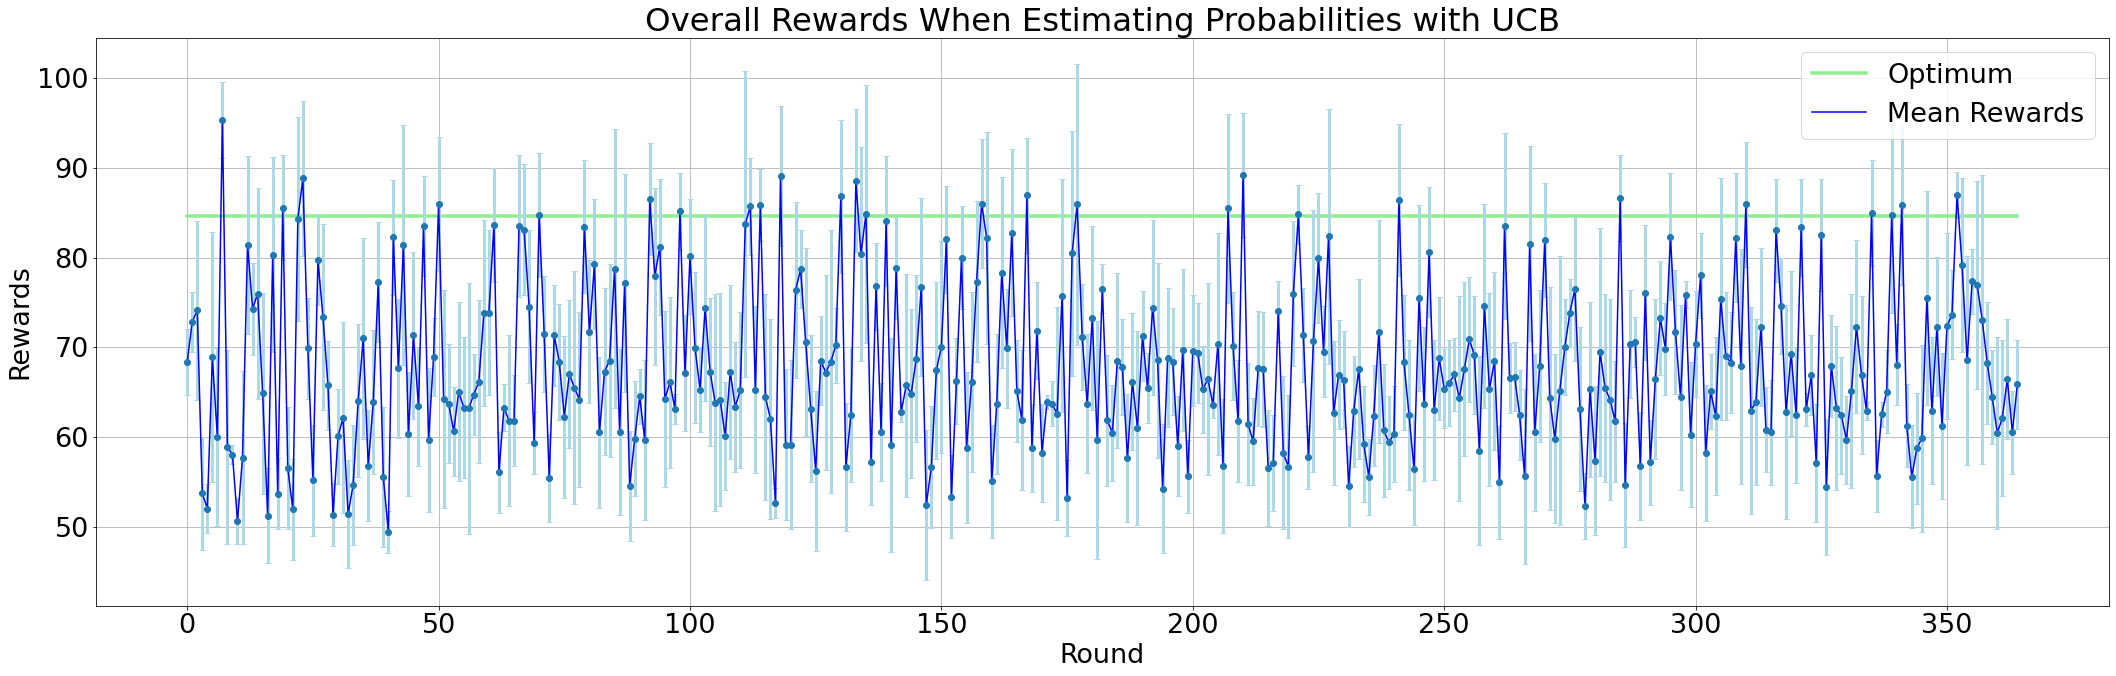

In [357]:
plt.figure(figsize=(30, 10))
plt.rcParams.update({'font.size': 17})  

plt.plot(time_periods, optimum_means1, color='lightgreen', linestyle='-', linewidth=3.5, label="Optimum")

plt.errorbar(time_periods, UCB_mean_rewards_per_round, yerr=UCB_std_dev_rewards_per_round, fmt='o', ecolor='lightblue', elinewidth=3, capsize=3)

plt.plot(time_periods, UCB_mean_rewards_per_round, color='blue', label='Mean Rewards')

plt.xlabel('Round')
plt.ylabel('Rewards')
plt.title('Overall Rewards When Estimating Probabilities with UCB')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




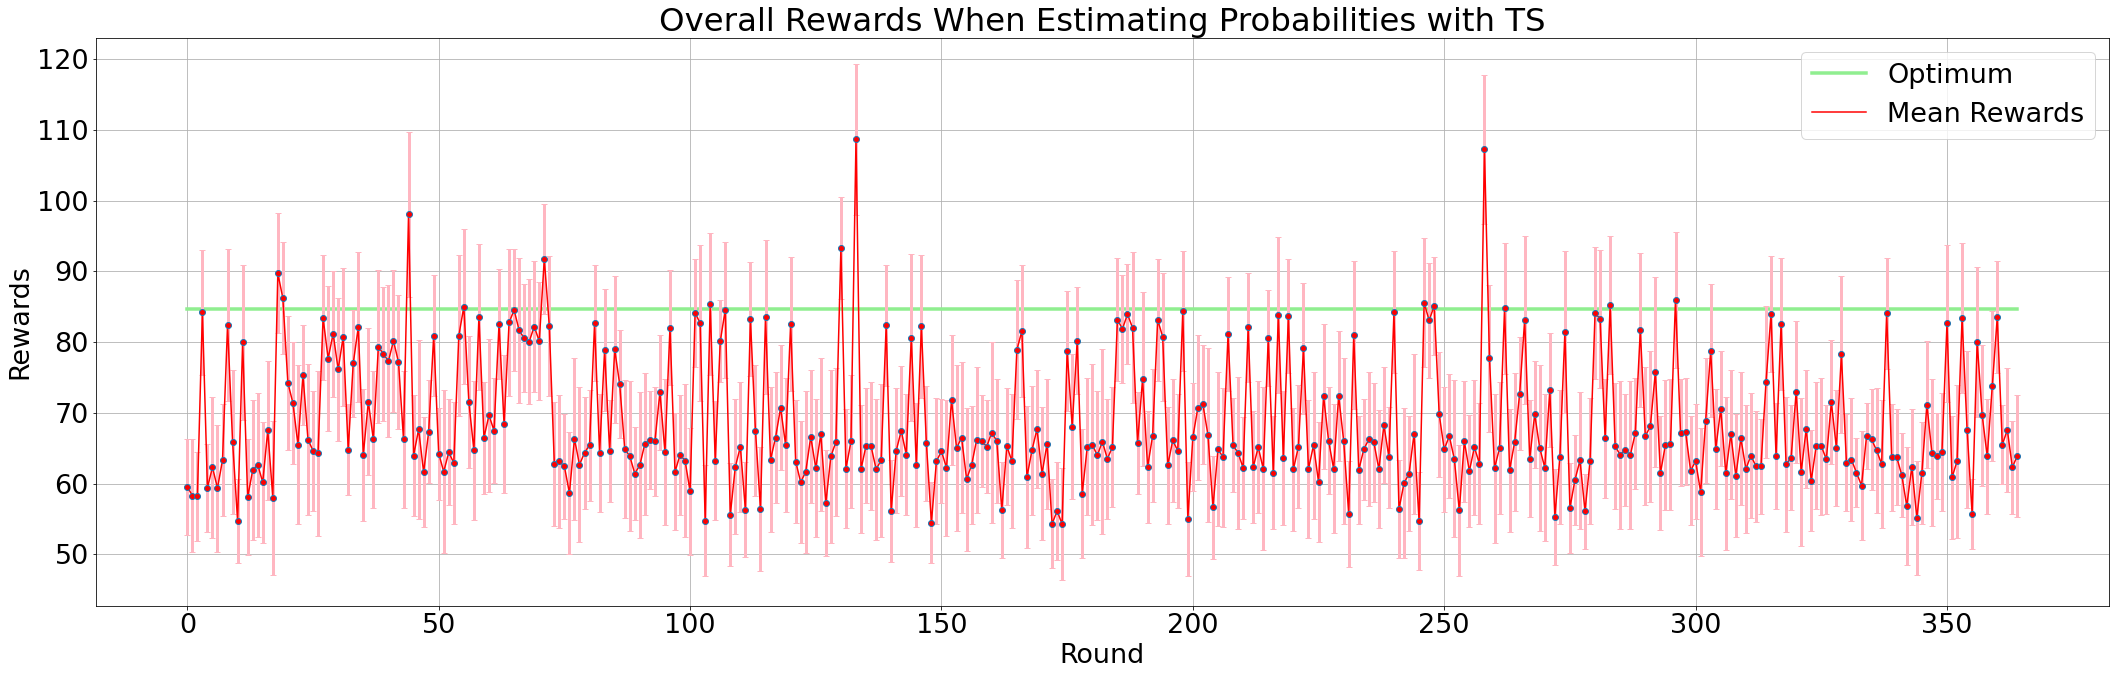

In [360]:
plt.figure(figsize=(30, 10))
plt.rcParams.update({'font.size': 17})  

plt.plot(time_periods, optimum_means1, color='lightgreen', linestyle='-', linewidth=3.5, label="Optimum")

plt.errorbar(time_periods, TS_mean_rewards_per_round, yerr=TS_std_dev_rewards_per_round, fmt='o', ecolor='lightpink', elinewidth=3, capsize=3, markerfacecolor='red')

plt.plot(time_periods, TS_mean_rewards_per_round, color='red', label='Mean Rewards')

plt.xlabel('Round')
plt.ylabel('Rewards')
plt.title('Overall Rewards When Estimating Probabilities with TS')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


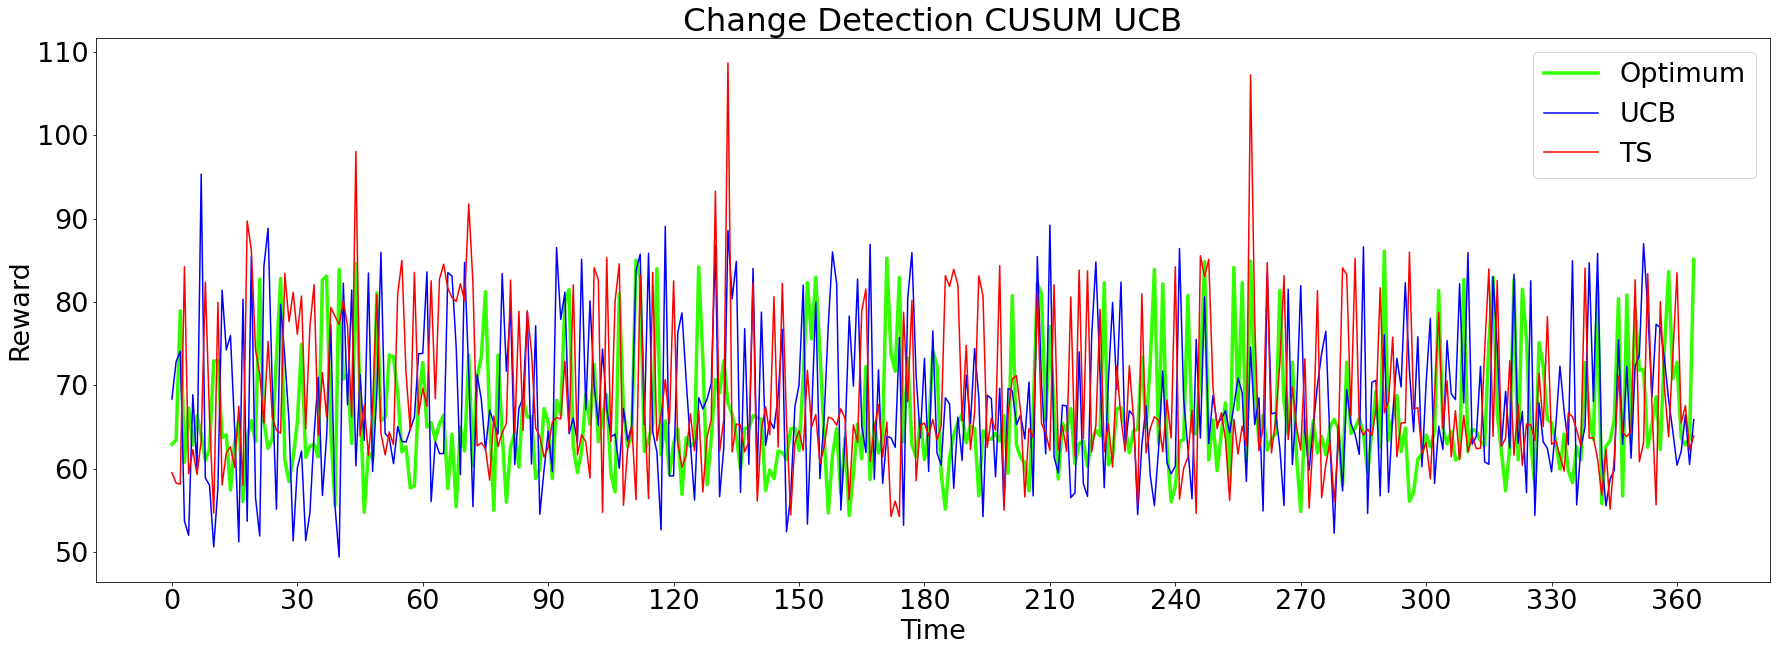

In [361]:
plt.figure(figsize=(30, 10))

plt.plot(time_periods, optimum_means, color='#34ff00', linestyle='-', linewidth=3.5, label="Optimum")
plt.plot(time_periods, UCB_mean_rewards_per_round, color='blue', linestyle='-', label="UCB")
plt.plot(time_periods, TS_mean_rewards_per_round, color='red', linestyle='-', label="TS")

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

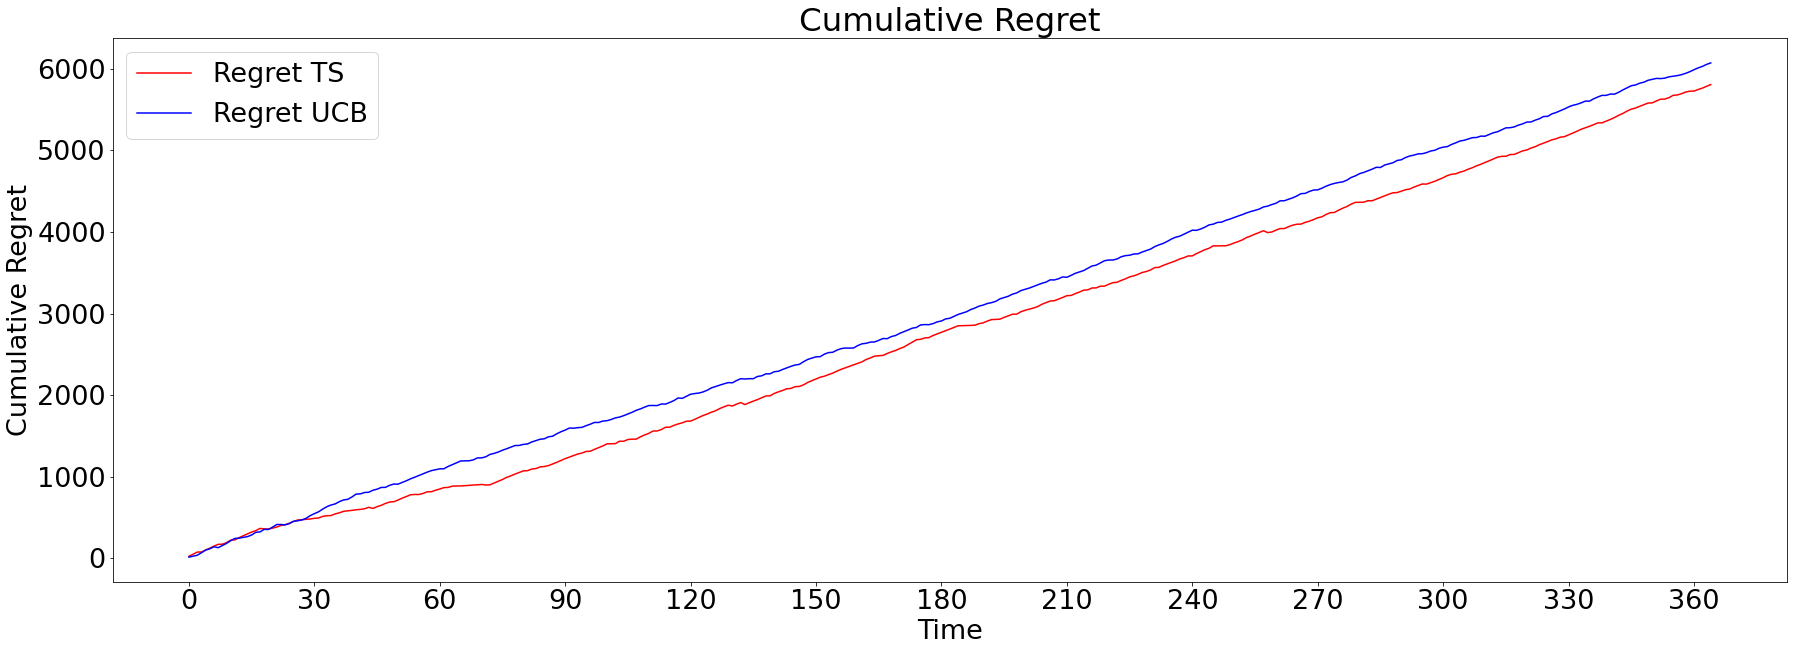

In [362]:

T = 365
time_periods = range(T)


diff_TS = np.cumsum([opt - ts for opt, ts in zip(optimum_means1, TS_mean_rewards_per_round)])
diff_UCB = np.cumsum([opt - ucb for opt, ucb in zip(optimum_means1, UCB_mean_rewards_per_round)])

plt.figure(figsize=(30, 10))

plt.plot(time_periods, diff_TS, color='red', linestyle='-', label="Regret TS")
plt.plot(time_periods, diff_UCB, color='blue', linestyle='-', label="Regret UCB")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret')

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

